# Iterative Solvers

In [108]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
from scipy import linalg as la

## Exercise 1/2

In [46]:
def jacobi(A, b, tol=10e-10, maxiters = 1000, plot = False):
    '''
    Function computes the inverse of Ax = b using the jacobi method.
    '''
    #get D, U, L.
    D = np.diag(A)
    U = np.triu(A)
    L = np.tril(A)
    Dinv = 1 / D #because D is diagonal
    
    #initialize
    n = len(b)
    x_k = np.zeros(n)
    dist = 20
    iters = 0
    abserrs = []
    while (dist > tol) & (iters < maxiters):
        x_kp1 = x_k + np.diag(Dinv) @ (b - A @ x_k)
        dist = np.linalg.norm(x_k - x_kp1)
        abserrs.append(dist)
        x_k = x_kp1
        iters += 1
    if plot:
        plt.semilogy(abserrs)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Jacobi method')
        plt.show()
    return x_k
        
def diag_dom(n, num_entries=None):
    """Generate a strictly diagonally dominant (n, n) matrix.
    Parameters:
    n (int): The dimension of the system.
    num_entries (int): The number of nonzero values.
    Defaults to n^(3/2)-n.
    Returns:
    A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    """
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A


In [47]:
#Test for Ex1
b = np.random.random(5)
A = diag_dom(5)

xstar = jacobi(A, b)
print('x =', xstar)
print("Are they close?", np.allclose(A @ (xstar), b))

x = [0.29969783 0.35330898 0.00525061 0.40690068 0.16419838]
Are they close? True


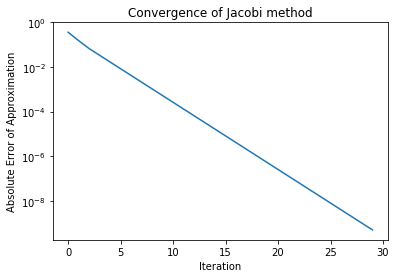

x = [0.03840429 0.25811578 0.16924941 0.37134564 0.09635183]
Are they close? True


In [50]:
#Test for Ex2
b = np.random.random(5)
A = diag_dom(5)

xstar = jacobi(A, b, plot = True)
print('x =', xstar)
print("Are they close?", np.allclose(A @ (xstar), b))

## Exercise 3

In [68]:
def gauss_seidel(A, b, tol = 10e-15, maxiters = 1000, plot = False):
    '''
    Function computes the inverse of Ax = b using the gauss-seidel method.
    '''
    #initialize
    n = len(b)
    x_k = np.zeros(n)
    x_kp1 = np.zeros(n)
    dist = 20
    iters = 0
    abserrs = []
    while (dist > tol) & (iters < maxiters):
        x_ksaved = x_k.copy()
        for i in range(n):
            x_k[i] = x_k[i] + (1/A[i, i]) * (b[i] - A[i, :].T @ x_k)
        dist = np.linalg.norm(x_ksaved - x_k)
        abserrs.append(dist)
        x_k = x_kp1
        iters += 1
    if plot:
        plt.semilogy(abserrs)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss-Seidel method')
        plt.show()
    return x_k


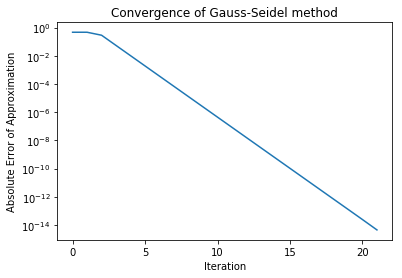

x = [0.35090207 0.26573356 0.50128644 0.15715458 0.178672  ]
Are they close? True


In [70]:
#Test for Ex2
b = np.random.random(5)
A = diag_dom(5)

xstar = gauss_seidel(A, b, plot = True)
print('x =', xstar)
print("Are they close?", np.allclose(A @ (xstar), b))

## Exercise 4

In [80]:
def sparse_gauss_seidel(A, b, tol = 10e-15, maxiters = 1000, plot = False):
    '''
    Version of above function which is modified to accept sparse matrices.
    
    I compute Aix using the method given in the ACME pdf.
    '''
    #initialize
    n = len(b)
    x_k = np.zeros(n)
    x_kp1 = np.zeros(n)
    dist = 20
    iters = 0
    abserrs = []
    while (dist > tol) & (iters < maxiters):
        x_ksaved = x_k.copy()
        for i in range(n):
            # Get the indices of where the i-th row of A starts and ends if the
            # nonzero entries of A were flattened.
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            # Multiply only the nonzero elements of the i-th row of A with the
            # corresponding elements of x.
            Aix = A.data[rowstart:rowend] @ x_k[A.indices[rowstart:rowend]]
            x_k[i] = x_k[i] + (1/A[i, i]) * (b[i] - Aix)
        dist = np.linalg.norm(x_ksaved - x_k)
        abserrs.append(dist)
        x_k = x_kp1
        iters += 1
    if plot:
        plt.semilogy(abserrs)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Gauss-Seidel method')
        plt.show()
    return x_k

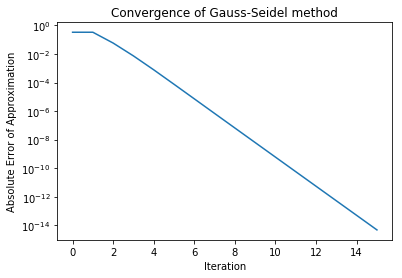

Are they close? True


In [82]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)

xstar = sparse_gauss_seidel(A, b, plot = True)
#print('x =', xstar)
print("Are they close?", np.allclose(A @ (xstar), b))

## Exercise 5

In [92]:
def sor(A, b, omega, tol = 10e-15, maxiters = 1000, plot = False):
    '''
    Version of above function which is modified to accept sparse matrices.
    
    I compute Aix using the method given in the ACME pdf.
    '''
    #initialize
    n = len(b)
    x_k = np.zeros(n)
    x_kp1 = np.zeros(n)
    dist = 20
    iters = 0
    abserrs = []
    while (dist > tol) & (iters < maxiters):
        x_ksaved = x_k.copy()
        for i in range(n):
            # Get the indices of where the i-th row of A starts and ends if the
            # nonzero entries of A were flattened.
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            # Multiply only the nonzero elements of the i-th row of A with the
            # corresponding elements of x.
            Aix = A.data[rowstart:rowend] @ x_k[A.indices[rowstart:rowend]]
            x_k[i] = x_k[i] + (omega/A[i, i]) * (b[i] - Aix)
        dist = np.linalg.norm(x_ksaved - x_k)
        abserrs.append(dist)
        x_k = x_kp1
        iters += 1
    if plot:
        plt.semilogy(abserrs)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Sucessive Over-Relaxation method')
        plt.show()
    return x_k, iters

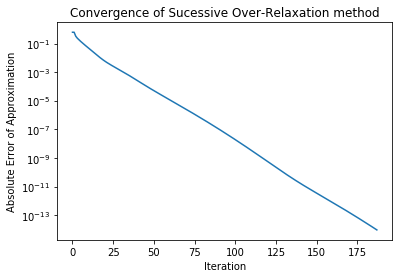

After 188 iterations,  x = 
 [ 9.84842550e-03  1.54573910e-02  1.18354481e-02  1.64404487e-02
  1.72795619e-02 -8.19853383e-04  2.95136603e-02  1.86304503e-02
  1.31638579e-02  2.02272133e-02  1.45962081e-02  1.62891274e-02
  3.09725661e-02  1.32501231e-02  9.85648219e-03  1.18971424e-02
  1.83713738e-02  2.22089406e-02  2.31357122e-02  3.46441373e-03
  2.70621756e-02  4.01397244e-02  2.51570671e-02  3.14983141e-02
  2.56105163e-02  7.07520420e-03  1.78228322e-02  3.11966291e-02
  2.25497133e-02  1.99521989e-02  1.61059575e-02  2.34157791e-04
  1.84871883e-02  7.82162437e-03  1.69306043e-02  1.97232835e-02
  1.52983342e-02  2.51930416e-02  1.91450707e-02  2.26336919e-02
  4.51678902e-03  2.03917490e-02  6.04794063e-03  2.89496762e-02
  2.79687629e-02  1.41723730e-02  1.74201385e-02  1.25712001e-02
  1.64394621e-02  2.04262178e-02  2.29670541e-02  3.64855429e-02
  1.40497897e-02  3.28326204e-02  1.90860551e-02  1.75970022e-02
  1.69413483e-02  2.10516259e-02  3.83731444e-02  7.56843787e

In [94]:
A = sparse.csr_matrix(diag_dom(500))
b = np.random.random(500)

xstar, iters = sor(A, b, 1.5, plot = True)
print(f'After {iters} iterations,  x = \n', xstar)
print("Are they close?", np.allclose(A @ (xstar), b))

## Exercise 6

In [164]:
def heattransfer(n, omega, tol=10e-8, maxiters = 100, plot = False):
    #Create A
    B = -4 * np.eye(n) + np.eye(n, k = 1) + np.eye(n, k = -1)
    I = np.eye(n)
    A = np.kron(np.eye(n), B) + np.kron(np.eye(n, k = 1), I) + np.kron(np.eye(n, k = -1), I)
    A = sparse.csr_matrix(A)
    #Create b
    b = np.zeros(n)
    b[0] = -100
    b[-1]= -100
    b = np.tile(b, n)
    result, iters = sor(A, b, omega, tol = tol, maxiters = maxiters)
    result = result.reshape(n, n)
    if plot:
        fig = plt.figure(figsize=(10, 8))
        plt.pcolormesh(result, cmap = 'jet')
        plt.colorbar()
        plt.title(f"Heat diffusion ({n} bins)")
    return result, iters

(array([[49.66088814, 29.56532842, 19.95293631, ..., 19.93281396,
         29.55844002, 49.66088814],
        [69.09208109, 48.6710272 , 35.71369297, ..., 35.67402511,
         48.65744959, 69.09208109],
        [78.0602579 , 60.3526587 , 47.08889773, ..., 47.03041351,
         60.33264294, 78.0602579 ],
        ...,
        [78.15253879, 60.5332287 , 47.35130346, ..., 47.29982683,
         60.51565485, 78.15253879],
        [69.15985439, 48.80360419, 35.90630018, ..., 35.87200317,
         48.79189663, 69.15985439],
        [49.69796753, 29.63784413, 20.05826019, ..., 20.04118413,
         29.63201572, 49.69796753]]), 100)

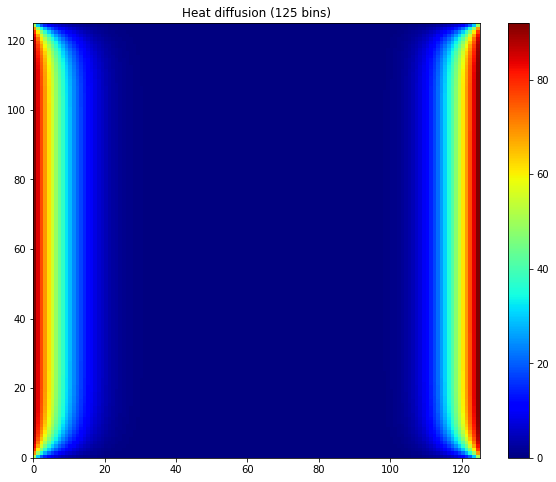

In [166]:
heattransfer(125, 1, plot=True)

## Exercise 7

In [173]:
def omegainvestigate(k, n):
    '''
    Function runs the heattransfer function with different values for 
    omega to see which returns with the smallest number of iterations.
    k is the number of different omegas
    n is the dimensionality of the problem
    '''
    omegagrid = np.linspace(1, 1.95, k)
    itertime = []
    for omega in omegagrid:
        result, iters = heattransfer(n, omega, tol = 1e-2, maxiters = 1000)
        itertime.append(iters)
    omegaopt = omegagrid[np.argmin(itertime)]
    plt.plot(omegagrid, itertime)
    plt.xlabel('Omega')
    plt.ylabel('Number of iterations')
    plt.title(f'Optimal Omega for heat transfer problem (dimension {n})')
    plt.show()
    return omegaopt

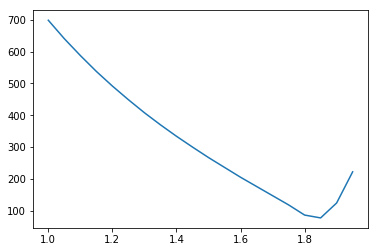

Optimal omega is near 1.85


In [175]:
omegaopt = omegainvestigate(20, 30)
print(f'Optimal omega is near {omegaopt}')